In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import scipy as sp
import seaborn as sns
#from plotting import annotate_corr
#from matplotlib.lines import Line2D
#from functools import partial
#from scipy import stats

sns.set(style='ticks', context='paper',
        rc={'font.size': 6, 
            'axes.titlesize': 7,
            'axes.labelsize': 7,
            'axes.labelpad': 2,
            'xtick.labelsize': 5,
            'ytick.labelsize': 5,
            'legend.title_fontsize' : 5.5,
            'legend.fontsize' : 5.5,
            'legend.markerscale': 0.5,
            'axes.spines.top': False,
            'axes.spines.right': False,
            'axes.linewidth': 0.4,
            'xtick.major.width': 0.4,
            'ytick.major.width': 0.4,
            'xtick.major.size': 2.5,
            'ytick.major.size': 2.5,
            'xtick.minor.size': 1.5,
            'ytick.minor.size': 1.5,
            'xtick.minor.width': 0.2,
            'ytick.minor.width': 0.2,
            'figure.constrained_layout.use': True,
            'figure.dpi': 200})

id_columns = ['architecture', 'task', 'kind', 'source', 'layer']

tf_to_pt_layer_map = {'encode_2': 'layer1.0.relu', 'encode_3': 'layer1.1.relu', 
                      'encode_4': 'layer2.0.relu', 'encode_5': 'layer2.1.relu', 
                      'encode_6': 'layer3.0.relu', 'encode_7': 'layer3.1.relu', 
                      'encode_8': 'layer4.0.relu', 'encode_9': 'layer4.1.relu'}


#data = pd.merge(pd.read_csv(f'/home/wtownle1/encoder_dimensionality/results_marcc/spatialPCA/eigspectra_untrained|dataset:{dataset}|pooling:spatial_pca|grayscale:False.csv'), pd.read_csv(f'/home/wtownle1/encoder_dimensionality/results_marcc/spatialPCA/eigmetrics_untrained|dataset:{dataset}|pooling:spatial_pca|grayscale:False.csv'),on=id_columns)


In [ ]:
#below = old variance scale

/home/wtownle1/.conda/envs/encoder-dimensionality/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/home/wtownle1/.conda/envs/encoder-dimensionality/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/home/wtownle1/.conda/envs/encoder-dimensionality/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/home/wtownle1/.conda/envs/encoder-dimensional

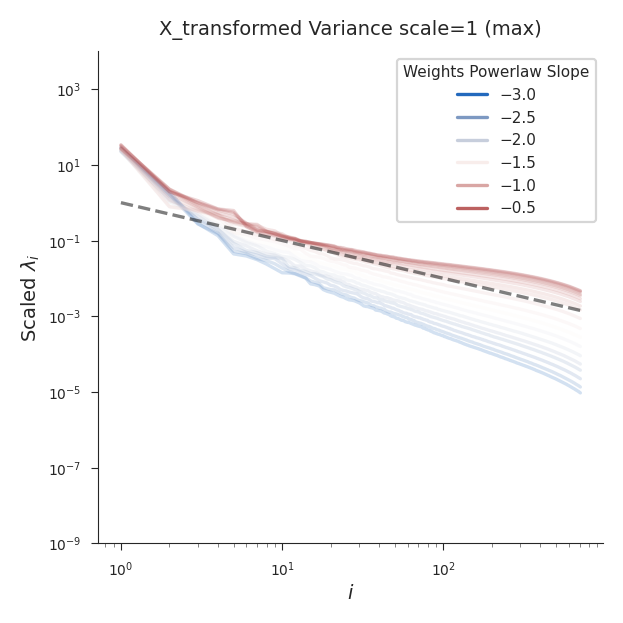

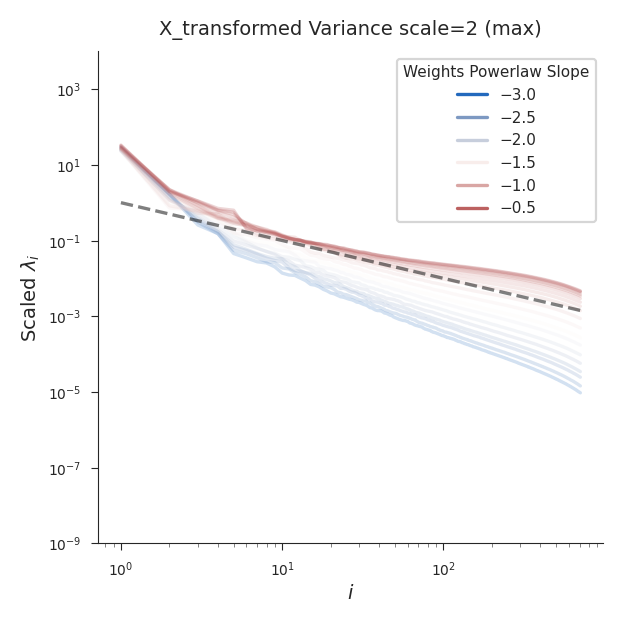

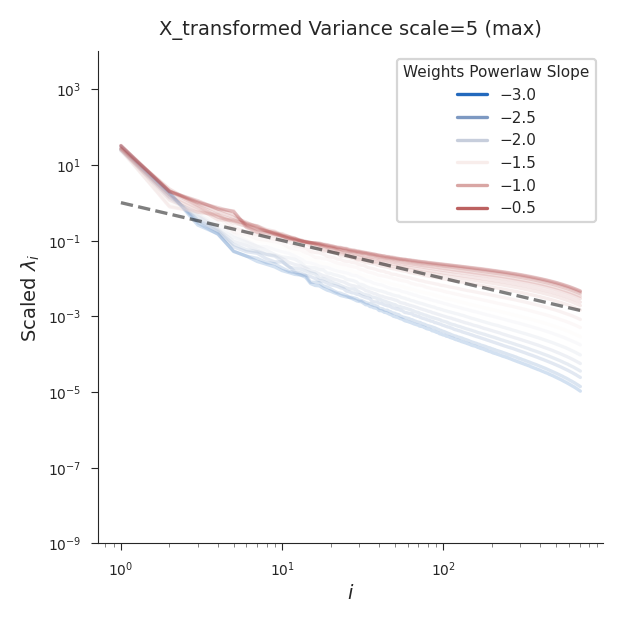

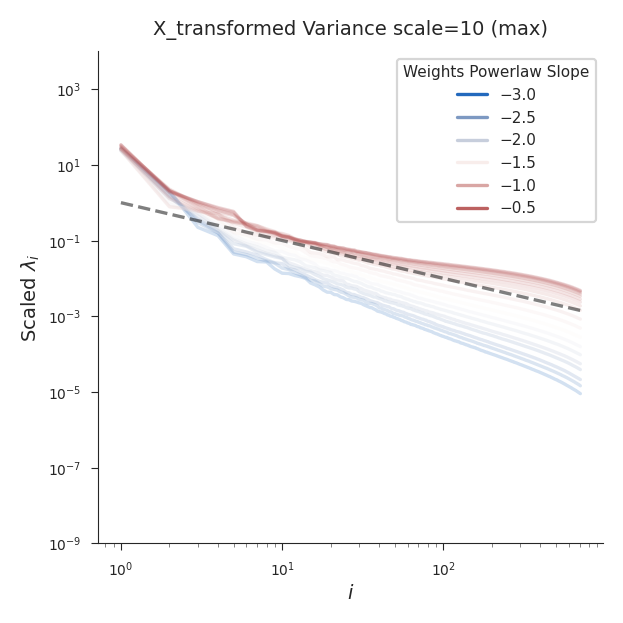

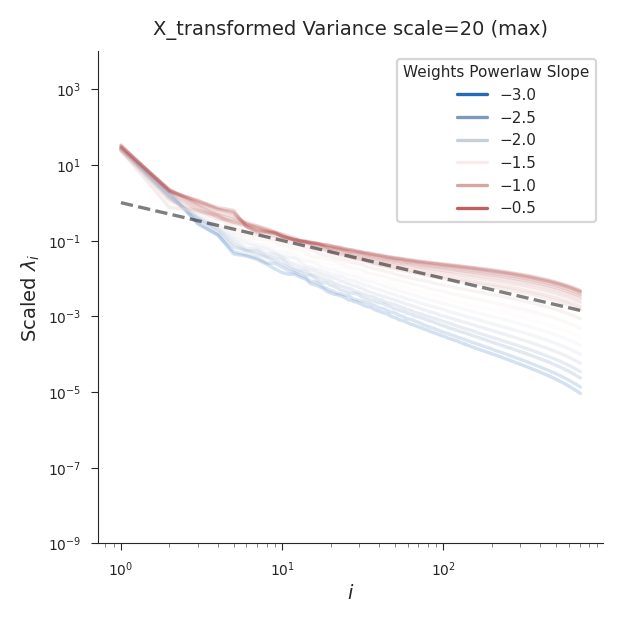

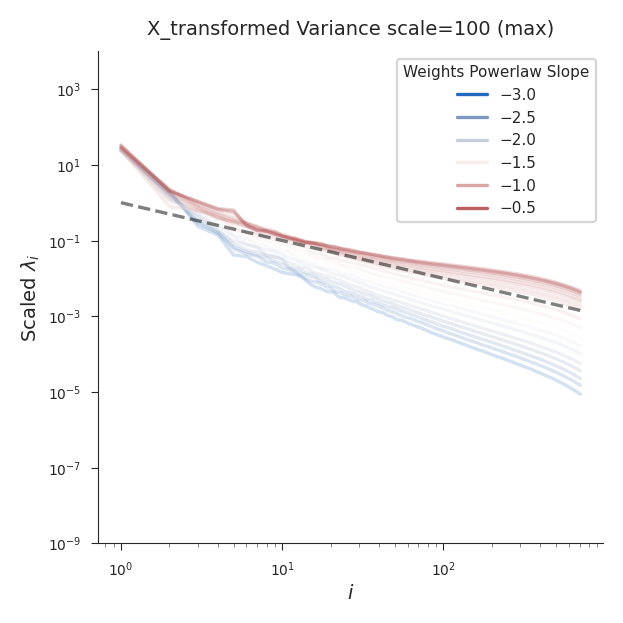

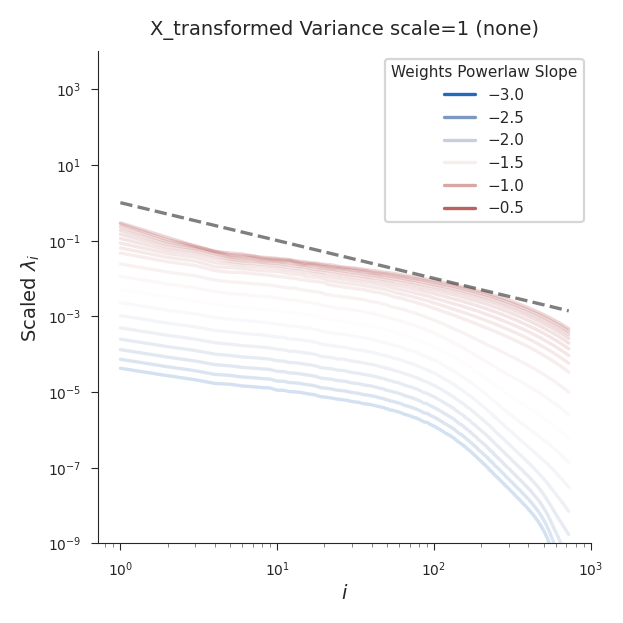

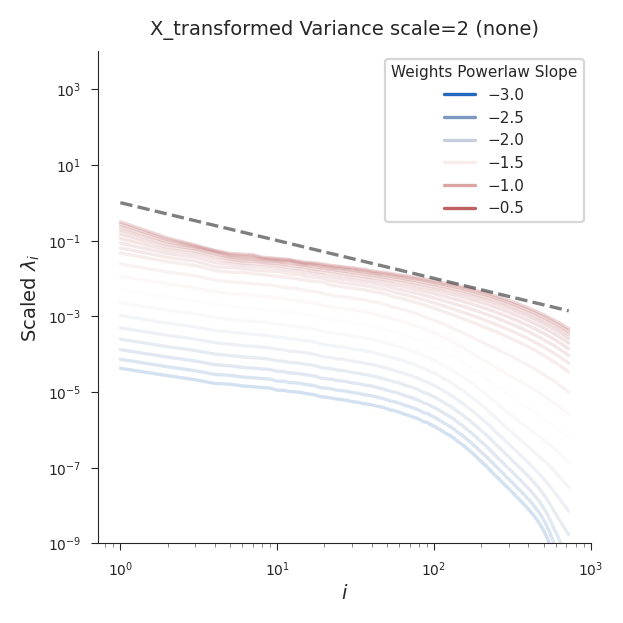

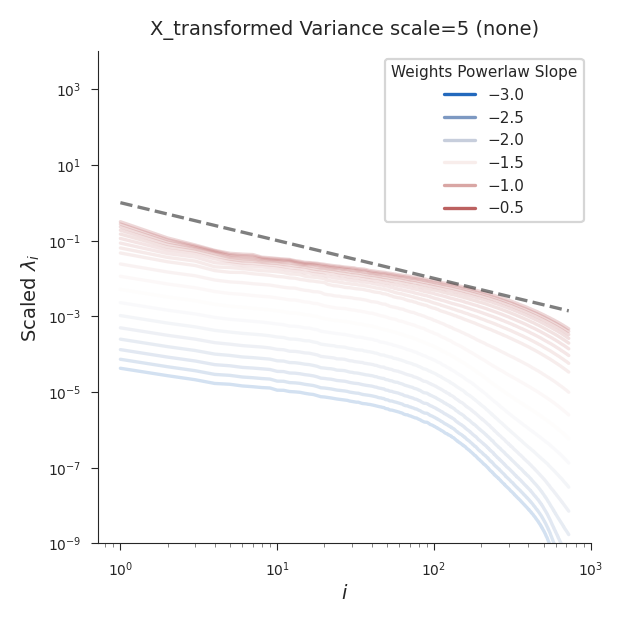

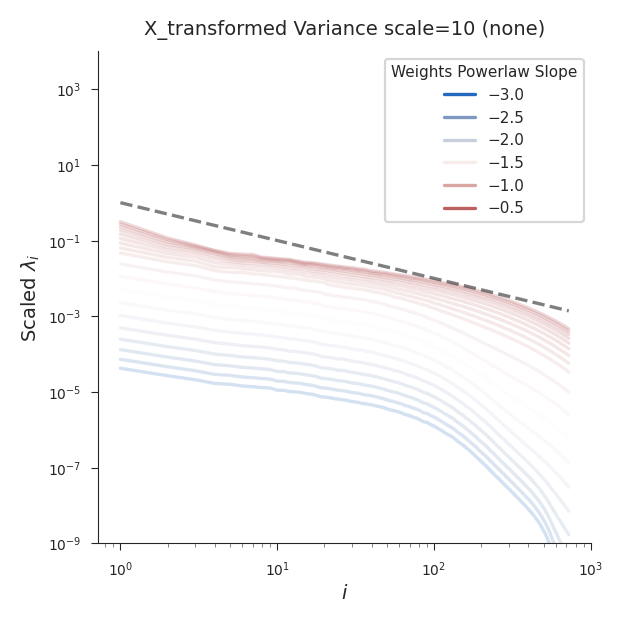

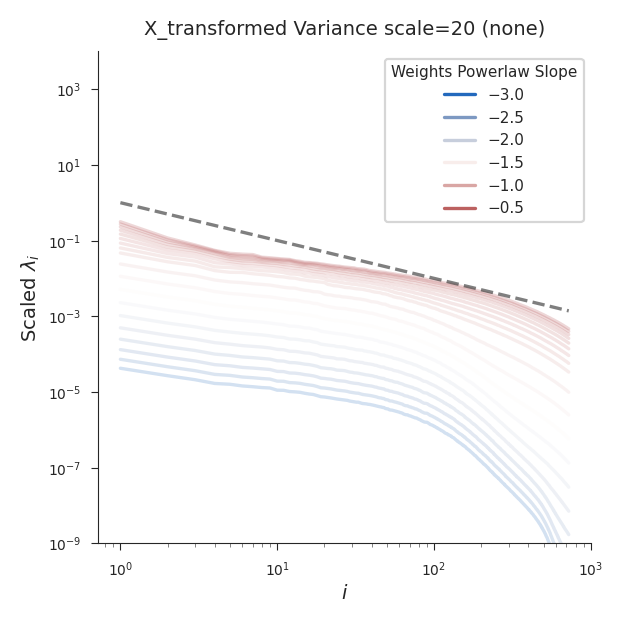

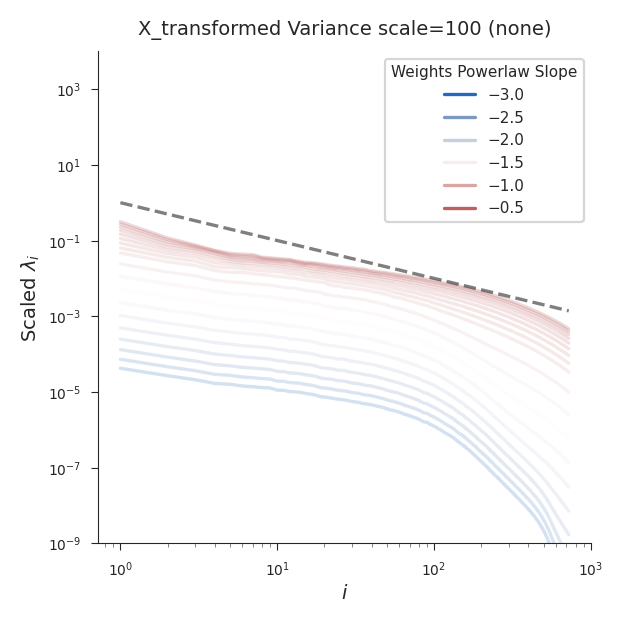

In [3]:
#Majaj metrics

files = ['Eig-Vscale']
v_scales = [1, 2, 5, 10, 20, 100]
pooling = ['max', 'none']
dataset = 'majajhong2015'

spectra = True
encoding = False
rsa = False

for p in pooling:
    for v in v_scales:


#eigenspectra

        if spectra:
            
            f = files[0]
            t = f'X_transformed Variance scale={v} ({p})'
            
            dm = pd.read_csv(f'../../../results_marcc/atlasnet/eigmetrics_{f}|dataset:{dataset}|pooling:{p}|grayscale:False.csv')
            ds = pd.read_csv(f'../../../results_marcc/atlasnet/eigspectra_{f}|dataset:{dataset}|pooling:{p}|grayscale:False.csv')
            data = pd.merge(dm, ds, on=id_columns)
            data['id'] = data[id_columns].sum(axis='columns')
            data = data[ (data['layer']=='c2') ]
            data = data[ (data['source']==v) ]
            
        # Remove outlier low-variance points at the final PCs
            def is_outlier(i):
                i = np.log(i)
                cutoff = 0.95 * i.iloc[-1]
                return i > cutoff
            outlier = data.groupby(id_columns)['n'].transform(is_outlier)
            data = data[~outlier]

        # Set y-intercept to 1
            def get_scaled_var(x):
                i, y = x['n'].values, x['variance'].values
                i, y = np.log(i), np.log(y)
                intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
                intercept = np.exp(intercept)
                return x['variance'] / intercept
            scaled_var = data.groupby(id_columns).apply(get_scaled_var)
            scaled_var = scaled_var.reset_index(id_columns, drop=True)
            data['scaled_variance'] = scaled_var

        # Log(ED)
            data['log_ed'] = np.log10(data['effective dimensionality'])

            fig, ax = plt.subplots(figsize=(3, 3))
            sns.lineplot(data=data, x='n', y='scaled_variance', hue='kind',
                        units='id', alpha=0.2, estimator=None,
                        palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
            ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
            ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title=t)
            ax.set_ylim(bottom=10**(-9), top=10**4)
            ax.legend(title='Weights Powerlaw Slope')
            #ax.legend(title=r'$\log{(ED)}$')
            #plt.show()
                
                
            #encoding score
            
        if encoding:
            f = files[0]
            regressions = ['pls', 'lin', 'ridge_alpha=1', 'ridge_alpha=10', 'ridge_alpha=100', 'ridge_alpha=1000']
            for reg in regressions:
                
                t = f'X_transformed Encoding ({reg}) Variance Scale={v}'
                
                dm = pd.read_csv(f'../../../results_marcc/atlasnet/eigmetrics_{f}|dataset:{dataset}|pooling:{p}|grayscale:False.csv')
                de = pd.read_csv(f'../../../results_marcc/atlasnet/encoding_{f}|benchmark:dicarlo.MajajHong2015.IT.public-{reg}|pooling:none.csv')
                data = pd.merge(de, dm, on=id_columns)
                data = data[ (data['layer']=='c2') ]
                data = data[ (data['source']==v) ]
                data['id'] = data[id_columns].sum(axis='columns')

                predictors = ['effective dimensionality', 'alpha']
                for pred in predictors:
                    r, p_val = sp.stats.pearsonr(data[pred], data['score'])

                    fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
                    sns.regplot(data=data, x=pred, y='score', 
                                logx=True,
                                scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
                                line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
                                ax=ax)
                    ax.set(xlabel=f'{pred} (pooling={p})', ylabel=r'Encoding score ($R^2$)', xscale='log', title=t)
                    ax.text(.05, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
                    #ax.set_ylim(bottom=0, top=0.65)
                    #ax.set_xlim(0.8, 270)
                
                
        
        if rsa:
            f = files[0]
            t = f'X_transformed RSA (Variance Scale={v})'
            for p2 in ['True', 'False']:
            
                dm = pd.read_csv(f'../../results_marcc/atlasnet/eigmetrics_{f}|dataset:{dataset}|pooling:{p}|grayscale:False.csv')
                de = pd.read_csv(f'../../results_marcc/atlasnet/rsa_{f}|benchmark:dicarlo.MajajHong2015.IT.public-rsa|pooling:{p2}.csv')
                #dm['task'] = de['task']
                data = pd.merge(de, dm, on=id_columns)
                data = data[ (data['layer']=='c2') ]
                data = data[ (data['source']==v) ]
                data['id'] = data[id_columns].sum(axis='columns')

                predictors = ['effective dimensionality', 'alpha']
                for pred in predictors:
                    r, p_val = sp.stats.pearsonr(data[pred], data['score'])

                    fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
                    sns.regplot(data=data, x=pred, y='score', 
                                logx=True,
                                scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
                                line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
                                ax=ax)
                    ax.set(xlabel=f'{pred} (pooling={p})', ylabel=rf'RDM $R^2$ (pooling={p2})', xscale='log', title=t)
                    ax.text(.05, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
                    #ax.set_ylim(bottom=0, top=0.65)
                    #ax.set_xlim(0.8, 270)

plt.show()

In [ ]:
#imagenet & majaj

files = ['Eig-Vscale', 'Eig-Vscale1000']
v_scales = [1, 2, 5, 10, 20, 100]
pooling = ['max', 'none']

id_columns = ['architecture', 'task', 'kind', 'source', 'layer']

for f in files:
    if f == 'Eig-Vscale':
        dataset = 'majajhong2015'
        for v in v_scales:
            for p in pooling:
                
                t = f'X_transformed Variance scale={v} ({p})'
                
                dm = pd.read_csv(f'../../results_marcc/atlasnet/eigmetrics_{f}|dataset:{dataset}|pooling:{p}|grayscale:False.csv')
                ds = pd.read_csv(f'../../results_marcc/atlasnet/eigspectra_{f}|dataset:{dataset}|pooling:{p}|grayscale:False.csv')
                data = pd.merge(dm, ds, on=id_columns)
                data['id'] = data[id_columns].sum(axis='columns')
                data = data[ (data['layer']=='c2') ]
                data = data[ (data['source']==v) ]
                
            # Remove outlier low-variance points at the final PCs
                def is_outlier(i):
                    i = np.log(i)
                    cutoff = 0.95 * i.iloc[-1]
                    return i > cutoff
                outlier = data.groupby(id_columns)['n'].transform(is_outlier)
                data = data[~outlier]

            # Set y-intercept to 1
                def get_scaled_var(x):
                    i, y = x['n'].values, x['variance'].values
                    i, y = np.log(i), np.log(y)
                    intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
                    intercept = np.exp(intercept)
                    return x['variance'] / intercept
                scaled_var = data.groupby(id_columns).apply(get_scaled_var)
                scaled_var = scaled_var.reset_index(id_columns, drop=True)
                data['scaled_variance'] = scaled_var

            # Log(ED)
                data['log_ed'] = np.log10(data['effective dimensionality'])

                fig, ax = plt.subplots(figsize=(3, 3))
                sns.lineplot(data=data, x='n', y='scaled_variance', hue='log_ed',
                            units='id', alpha=0.2, estimator=None,
                            palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
                ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
                ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title=t)
                ax.set_ylim(bottom=10**(-9), top=10**4)
                #ax.legend(title='Weights Powerlaw Slope')
                ax.legend(title=r'$\log{(ED)}$')
                #plt.show()


    elif f == 'Eig-Vscale1000':
        dataset = 'imagenet'
        for p in pooling:
        
            t = f'X_transformed Variance scale=1000 ({p})'
            
            dm = pd.read_csv(f'../../results_marcc/atlasnet/eigmetrics_{f}|dataset:{dataset}|pooling:{p}|grayscale:False.csv')
            ds = pd.read_csv(f'../../results_marcc/atlasnet/eigspectra_{f}|dataset:{dataset}|pooling:{p}|grayscale:False.csv')
            data = pd.merge(dm, ds, on=id_columns)
            data['id'] = data[id_columns].sum(axis='columns')
            data = data[ (data['layer']=='c2') ]
            
        # Remove outlier low-variance points at the final PCs
            def is_outlier(i):
                i = np.log(i)
                cutoff = 0.95 * i.iloc[-1]
                return i > cutoff
            outlier = data.groupby(id_columns)['n'].transform(is_outlier)
            data = data[~outlier]

        # Set y-intercept to 1
            def get_scaled_var(x):
                i, y = x['n'].values, x['variance'].values
                i, y = np.log(i), np.log(y)
                intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
                intercept = np.exp(intercept)
                return x['variance'] / intercept
            scaled_var = data.groupby(id_columns).apply(get_scaled_var)
            scaled_var = scaled_var.reset_index(id_columns, drop=True)
            data['scaled_variance'] = scaled_var

        # Log(ED)
            data['log_ed'] = np.log10(data['effective dimensionality'])

            fig, ax = plt.subplots(figsize=(3, 3))
            sns.lineplot(data=data, x='n', y='scaled_variance', hue='log_ed',
                        units='id', alpha=0.2, estimator=None,
                        palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
            ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
            ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title=t)
            ax.set_ylim(bottom=10**(-9), top=10**4)
            #ax.legend(title='Weights Powerlaw Slope')
            ax.legend(title=r'$\log{(ED)}$')
            #plt.show()
        

plt.show()